## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».  
    В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  
    Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
*  сalls — количество звонков,
*  minutes — суммарная длительность звонков в минутах,
*  messages — количество sms-сообщений,
*  mb_used — израсходованный интернет-трафик в Мб,
*  is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Шаг 1. Откроем файл с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    users_behavior = pd.read_csv('D:/Users/Иван/Downloads/Модель классификации для сотового оператора/users_behavior.csv')
except:
    users_behavior = pd.read_csv('/datasets/users_behavior.csv')
                                 
users_behavior.info()                              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
users_behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Видно, что предобработка данных уже выполнена, пропусков нет, все данные в нужном формате. Целевым признаком, согласно описанию, будет столбец is_ultra. Остальные признаки помогут нам предсказывать решение по столбцу is_ultra.

## Шаг 2. Рaзобьем данные на выборки:

Так как отдельной таблицы для тестирования не предоставлено, разбивать данные **train / valid / test** будем согласно теории на  **60%, 20% и 20%**. Также проверим сбалансированность целевого признака в **target**.

In [4]:
features = users_behavior.drop(['is_ultra'], axis=1)
target = users_behavior['is_ultra']
target.value_counts()

is_ultra
0    2229
1     985
Name: count, dtype: int64

При помощи функции **value_counts()** стало понятно, что есть дисбаланс. Его мы подправим в **train_test_split** при помощи гиперпараметра **stratify**:

In [5]:
features, features_test, target, target_test = train_test_split(
    features, target, test_size=0.2, random_state=23042020, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.75, random_state=23042020, stratify=target)

print('Размер тренериующей выборки', features_train.shape[0])
print('Распределение баланса тренериующей выборки', target_train.value_counts())
print('Размер валидационной выборки', features_valid.shape[0])
print('Распределение баланса валидационной выборки', target_valid.value_counts())
print('Размер тестовой выборки', features_test.shape[0])
print('Распределение баланса тестовой выборки', target_test.value_counts())

Размер тренериующей выборки 1928
Распределение баланса тренериующей выборки is_ultra
0    1337
1     591
Name: count, dtype: int64
Размер валидационной выборки 643
Распределение баланса валидационной выборки is_ultra
0    446
1    197
Name: count, dtype: int64
Размер тестовой выборки 643
Распределение баланса тестовой выборки is_ultra
0    446
1    197
Name: count, dtype: int64


Модель, которая на валидационной выборке покажет лучшие результаты, будет применена на данных **features_test**.

## Шаг 3. Исследуем модели:

Исследуем качество разных моделей, меняя гиперпараметры. В качестве дополнительного параметра введём время выполнения рассчётов. Также для дальнейшей визуализации соберём информаци о результате каждого алгоритма. Начнём с **Decision Tree Classifier**:

In [6]:
model_name = []
best_results = []

In [7]:
%%time

best_depth = 0
best_accuracy = 0
dtc = []
tree_depth = []

for depth in range(1, 23):
    model = DecisionTreeClassifier(random_state=23042020, max_depth=depth)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, valid_predictions)
    dtc.append(accuracy)
    tree_depth.append(depth)
    if accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = accuracy

print('Лучшая глубина дерева', best_depth,'Лучшая точность', best_accuracy)

model_name.append('DecisionTreeClassifier')
best_results.append(best_accuracy)

Лучшая глубина дерева 4 Лучшая точность 0.7916018662519441
CPU times: total: 109 ms
Wall time: 138 ms


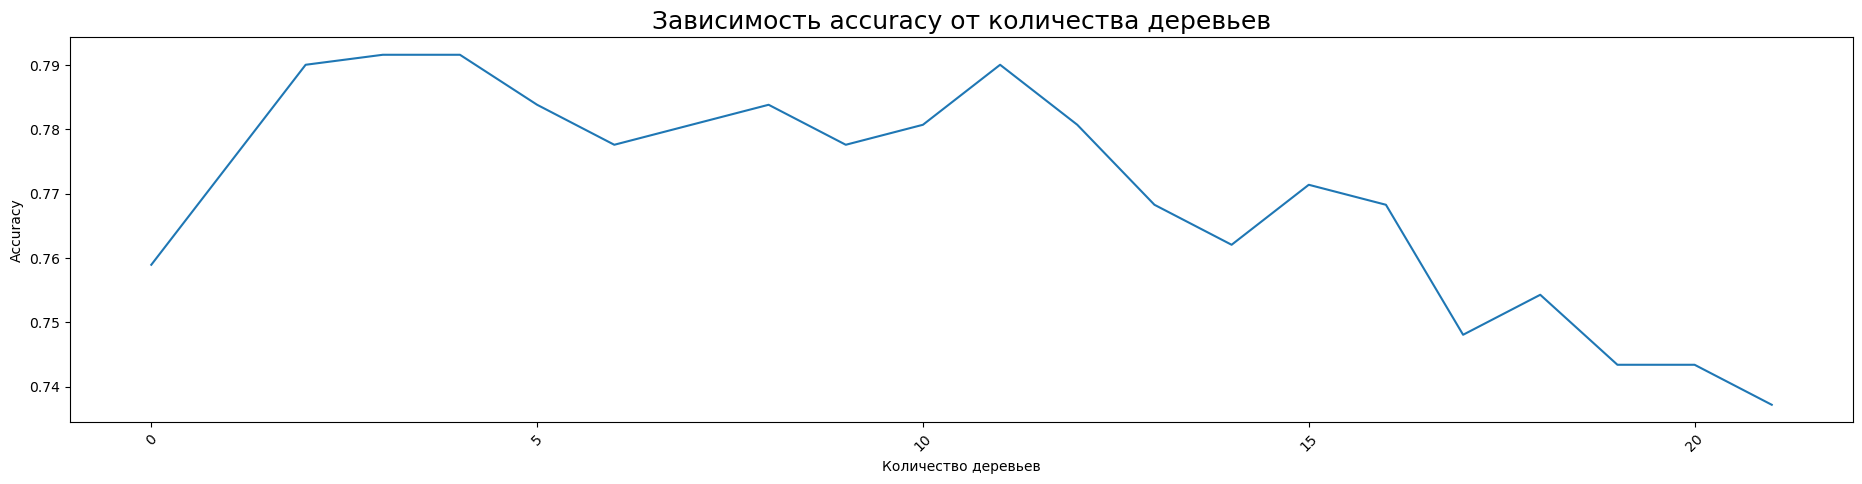

In [8]:
dtc_plot = pd.DataFrame({"accuracy":dtc})
# ax=dtc_plot.plot(kind='bar', figsize=(23, 2), rot=45)


ax=dtc_plot.plot(figsize=(23, 5), rot=45)


ax.get_legend().remove()
plt.title('Зависимость accuracy от количества деревьев', size=18)
plt.xlabel('Количество деревьев')
plt.ylabel('Аccuracy')
plt.show()

In [9]:
dtc_plot

,accuracy
0,0.758942
1,0.774495
2,0.790047
3,0.791602
4,0.791602
5,0.783826
6,0.777605
7,0.780715
8,0.783826
9,0.777605


Выяснили, что лучшая точность при глубине дерева 3.

**Random Forest Classifier:**

In [11]:
best_criterion = None
best_depth = 0
best_accuracy = 0
best_est = 0

for crit in tqdm(['gini', 'entropy']):
    for est in range(30,35):
        for depth in range(5,15):
            model = RandomForestClassifier(random_state=23042020, criterion=crit,
                                    max_depth=depth, n_estimators=est)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = model.score(features_valid, target_valid)
            if result > best_accuracy:
                best_criterion = crit
                best_depth = depth
                best_accuracy = result
                best_est = est
print('Критерий:', best_criterion, 'Количество деревьев:', best_est, 'Глубина:',
      best_depth, 'Результат:', best_accuracy)

model_name.append('RandomForestClassifier')
best_results.append(best_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.13s/it]

Критерий: entropy Количество деревьев: 30 Глубина: 14 Результат: 0.8180404354587869


Пробуем **GridSearchCV** для наилучшего подбора гиперпараметров **RandomForestClassifier**:

In [12]:
%%time

from sklearn.model_selection import GridSearchCV 
clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,15, 1),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
grid = GridSearchCV(clf, parametrs)
grid.fit(features_train, target_train)

CPU times: total: 10min
Wall time: 10min 7s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)})

Выводим наилучшее сочетание гиперпараметров:

In [13]:
grid.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=7, min_samples_split=6,
                       n_estimators=30)

Выводим лучшее **accuracy** при таком сочетании:

In [14]:
grid.best_score_

0.821056456496871

Повторяем эксперимент, уже вручную:

In [15]:
model = RandomForestClassifier(max_depth=12, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=50, criterion='entropy')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = model.score(features_valid, target_valid)
print(result)

0.7978227060653188


**Logistic Regression:**

In [16]:
%%time

best_max_iter = 0
best_accuracy = 0

for max_iter in range(1,101, 2):
    model = LogisticRegression(random_state=23042020, max_iter=max_iter, 
                              solver='newton-cg', penalty='l2')
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, valid_predictions)
    if accuracy > best_accuracy:
        best_max_iter = max_iter
        best_accuracy = accuracy

print('Лучшая количество итерраций', best_max_iter,'Лучшая точность', best_accuracy)    

model_name.append('LogisticRegression')
best_results.append(best_accuracy)

Лучшая количество итерраций 51 Лучшая точность 0.7511664074650077
CPU times: total: 7.44 s
Wall time: 1.3 s


**SVC:**

In [17]:
%%time

model = SVC(random_state=23042020)
model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid)
best_accuracy = model.score(features_valid, target_valid)

print('Лучшая точность', best_accuracy)

model_name.append('SVC')
best_results.append(best_accuracy)

Лучшая точность 0.7558320373250389
CPU times: total: 125 ms
Wall time: 133 ms


**KNeighbors Classifier:**

In [18]:
%%time

best_neighbors = 0
best_model = None
best_accuracy = 0
for neighbors in range(1, 15, 2):
    model = KNeighborsClassifier(n_neighbors=neighbors)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_accuracy:
        best_neighbors = neighbors
        best_model = model
        best_accuracy = result
print('Cоседи:', best_neighbors, 'результат:', best_accuracy)

model_name.append('KNeighborsClassifier')
best_results.append(best_accuracy)

Cоседи: 13 результат: 0.7744945567651633
CPU times: total: 203 ms
Wall time: 199 ms


Для наглядности построим упорядоченную гистограмму с точной информацией о каждом столбце:

In [19]:
top_models = pd.DataFrame({"algorithm_name":model_name, "accuracy":best_results})
top_models.sort_values('accuracy', inplace=True)
top_models.reset_index(inplace=True)
top_models

,index,algorithm_name,accuracy
0,3,LogisticRegression,0.751166
1,4,SVC,0.755832
2,5,KNeighborsClassifier,0.774495
3,0,DecisionTreeClassifier,0.791602
4,1,RandomForestClassifier,0.818040
5,2,RandomForestClassifier,0.818040


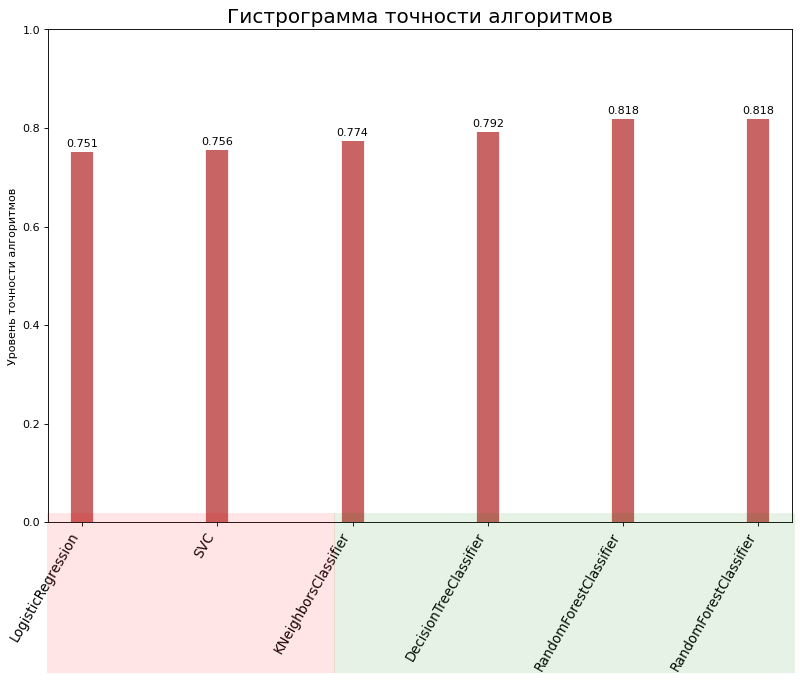

In [20]:
# Draw plot
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12,8), facecolor='white', dpi= 80)
ax.vlines(x=top_models.index, ymin=0, ymax=top_models.accuracy, color='firebrick', alpha=0.7, linewidth=20)

# Annotate Text
for i, accuracy in enumerate(top_models.accuracy):
    ax.text(i, accuracy+0.01, round(accuracy, 3), horizontalalignment='center')


# Title, Label, Ticks and Ylim
ax.set_title('Гистрограмма точности алгоритмов', fontdict={'size':18})
ax.set(ylabel='Уровень точности алгоритмов', ylim=(0, 1))
plt.xticks(top_models.index, top_models.algorithm_name, rotation=60, horizontalalignment='right', fontsize=12)

# Add patches to color the X axis labels
p1 = patches.Rectangle((.423, -0.125), width=.480, height=.25, alpha=.1, facecolor='green', transform=fig.transFigure)
p2 = patches.Rectangle((.124, -0.125), width=.300, height=.25, alpha=.1, facecolor='red', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.show()

**Вывод:** Хуже всего себя показали логистическая регрессия и метод опорных векторов, на третьем месте сортировка по соседям, а победил случайный лес. В продакшн мы можем брать случайный лес с параметрами глубины 14 и количеством деревьев 30.

## 4. Проверим две лучшие модели на тестовой выборке:

In [21]:
%%time

best_forest_model = RandomForestClassifier(random_state=23042020, criterion='gini',
                               max_depth=14, n_estimators=30)
best_forest_model.fit(features_train, target_train)
predictions = best_forest_model.predict(features_test)
accuracy = best_forest_model.score(features_test, target_test)
accuracy

CPU times: total: 109 ms
Wall time: 123 ms


0.7947122861586314

**Выводы:**
на тестовой выборке модель **DecisionTreeClassifier** показала себя довольно хорошо.


## 5. Проверим модель на адекватность:

Существуют несколько способов проверки модели на адекватность:  
Оценить адекватность модели можно используя несколько метрик:

-  **accuracy** - точность совпадения прогнозов с правильными ответами.
-  **precision** - отношение правильно предсказанных классов равных 1(TP) к сумме правильно предсказанных классов равных 1(TP) с неправльными предсказаниями, указанные как 1(FP).
-  **recall** - отношение правильно предсказанных классов равных 1(TP) к сумме правильно предсказанных классов равных 1(TP) с неправльными предсказаниями, указанные как 0(FN).

In [22]:
model = RandomForestClassifier(random_state=23042020, criterion='gini',
                               max_depth=10, n_estimators=31)
model.fit(features_train, target_train)

test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
print('Accuracy =', accuracy, 'Precision =', precision, 'Recall =', recall)

Accuracy = 0.7869362363919129 Precision = 0.7083333333333334 Recall = 0.5177664974619289


Для оценки адеватности используется **F-мера** - среднее гармоническое между **precision** и **recall**. Если хотя бы один из параметров близок к нулю, то и **F-мера** стремится к 0. Если оба стремятся к 1, то **F-мера** тоже стремится к 1.

In [23]:
f_score = f1_score(target_test, test_predictions)
print('F-мера =', f_score)

F-мера = 0.5982404692082111


Также при помощи DummyClassifier сделаем прогноз, который будет игнорировать входные функции:

In [24]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(features_test, target_test)
dummy_clf.predict(features_train)
dummy_clf.score(features_test, target_test)

0.6936236391912908

**Вывод:** Модель **RandomForestClassifier** получилась хорошего качества, показав результаты значительно лучше простой "угадайки". И для таких задач она адекватна.

## Итоговый вывод:
1. Изучен файл с данными.
2. Разбиты данные на три выборки с учетом дисбаланса в таргете: обучающая, валидационная и тестовая.
3. Исследованы три модели классификации: Решающее дерево, Случайный лес и Логистическая регрессия.
4. Найдены оптимальные параметры для каждой модели и выбрана одна из них для обучения модели.
5. Оценена точность обученной модели.
6. Оценена адекватность модели.

Для обучения модели было использована выборка в 2000 значений. Этого может быть недостаточно для повышения ключевых параметров модели классификатора. Увеличение в 10 или 100 увеличит accuracy, precision и recall, а также время обучения.

Адекватность модели повышается с ростом количества значений.